### Project 4 - Mobile Robotics - MO651
#### __Professor:__ _Esther Luna Columbini_ <br>
__Students:__ <br>
<table style="margin:0; padding:3px;">
    <tr><td><em>Tito Barbosa Rezende </td><td><strong>RA:</strong> 025327</td></tr>
<tr><td><em>João Paulo Franco Assumpção </td><td><strong>RA:</strong> 229322</td></tr>
<tr><td><em>Elcio Pereira de Souza Junior </td><td><strong>RA:</strong> 262952</td></tr></table>

### Pre-requisites

Necessary libraries:

In [ ]:
%pip install matplotlib
%pip install numpy
%pip install opencv-python
%pip install scikit-fuzzy
%pip install scikit-image
%pip install sklearn

Import libraries:

In [1]:
import sys, time
sys.path.insert(0, '../src')
from IPython.display import clear_output
from robot import Robot
import utils
import matplotlib.pyplot as plt
import numpy as np
import vrep
import math
import random
import collections
from datetime import datetime
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import lidar_to_grid_map as lg
import grid_map_lib as gm
import operator
from enum import IntEnum
from skimage.feature import corner_harris, corner_peaks, canny
from skimage.measure import find_contours
from skimage.morphology import remove_small_objects, skeletonize

### 1.1 Laser Sensor

In [2]:
class Laser_sensor:
    def __init__(self,robot):
        self.robot = robot

    def update_robot_frame_reading(self):
        laser_flatten_readings = np.array(self.robot.read_laser())
        laser_readings = laser_flatten_readings.reshape((len(laser_flatten_readings)//3, 3))
        self.laser_x = laser_readings[:,0]
        self.laser_y = laser_readings[:,1]

    def plot_laser_robot_frame(self):
        ox = self.laser_x
        oy = self.laser_y
        plt.figure(figsize=(6,10))
        plt.plot([oy, np.zeros(np.size(oy))], [ox, np.zeros(np.size(oy))], "ro-") # lines from 0,0 to the 
        plt.axis("equal")
        bottom, top = plt.ylim()  # return the current ylim
        plt.ylim((top, bottom)) # rescale y axis, to match the grid orientation
        plt.grid(True)
        plt.show()

### 1.2 Sonar Sensors

In [3]:
class Us_sensor:
    def __init__(self,robot):
        orientation_angles = np.array([90,50,30,10,-10,-30,-50,-90,-90,-130,-150,-170,170,150,130,90])
        orientation_rad = np.radians(orientation_angles)
        self.data = {
        "prefix" : "Pioneer_p3dx_ultrasonicSensor",
        "ids" : np.arange(1,17,1), "handles" : np.zeros(16, dtype=int), 
        "positions" :  np.zeros((16,3),dtype=float),
        "angles_deg": orientation_angles,
        "angles_rad": orientation_rad,
        "raw_reading": np.zeros(16),
        "robot_frame_reading": np.zeros((16,2),dtype=float)
        }
        self.robot = robot
        
        for i,sensor_i in enumerate(self.data['ids']):
            ret,handle = vrep.simxGetObjectHandle(self.robot.clientID, self.data['prefix'] + str(sensor_i), vrep.simx_opmode_oneshot_wait)
            self.data['handles'][i] = handle
            ret, pos = vrep.simxGetObjectPosition(self.robot.clientID, handle, self.robot.robot_handle, vrep.simx_opmode_oneshot_wait)
            self.data['positions'][i,:] = pos
        
    def get_left_distance(self):
        self.update_raw_reading()
        return np.min(np.array(self.data["raw_reading"][0]))
    
    def get_front_distance(self):
        self.update_raw_reading()
        return np.min(np.array([self.data["raw_reading"][3:5]]))        
    
    def get_right_distance(self):
        self.update_raw_reading()
        return np.min(np.array([self.data["raw_reading"][7:9]]))
    
    def update_raw_reading(self):
        self.data["raw_reading"] = np.array(self.robot.read_ultrassonic_sensors())
    
    def update_robot_frame_reading(self):
        self.update_raw_reading()
        for i, proximity in enumerate(self.data["raw_reading"]):
            if proximity == 5 or proximity < 0.1:
                self.data["robot_frame_reading"][i] = np.zeros(2)
            else:
                self.data["robot_frame_reading"][i] = self.proximity_robot_frame(i+1,proximity).flatten()
                
    #Calcula o ponto no frame do robo, referente a leitura de cada sensor de proximidade
    def proximity_robot_frame(self,sensorId, proximity):
        index = sensorId -1
        angulars = self.data["angles_rad"][index]
        #Matriz de rotação
        rot_matrix = np.array([[math.cos(angulars),-math.sin(angulars)],[math.sin(angulars),math.cos(angulars)]])
        #Rotacionando a leitura
        distXY = np.dot(rot_matrix , np.array([[proximity],[0]]))
        #Matriz de translação
        posicao_sensor_x = self.data["positions"][index][0]
        posicao_sensor_y = self.data["positions"][index][1]
        transXY=np.array([[distXY[0][0]+posicao_sensor_x],[distXY[1][0]+posicao_sensor_y]])
        return transXY

We defined __toGlobal__ function to enable a later using. The function transform any _(x,y)_ point of robot reference into a global reference.

In [4]:
def toGlobal(robot_x, robot_y,robot_ang, Point_xr, Point_yr):
    T_trans = np.array([[1,0,robot_x],[0,1,robot_y],[0,0,1]])
    T_rot = np.array([[math.cos(robot_ang),-math.sin(robot_ang),0],[math.sin(robot_ang),math.cos(robot_ang),0],[0,0,1]])
    T = np.dot(T_trans,T_rot)
    res = np.dot(T, np.array([Point_xr,Point_yr,1]))
    return res[0],res[1]
def fromGlobal(robot_x, robot_y,robot_ang, Point_xr, Point_yr):
    T_trans = np.array([[1,0,-robot_x],[0,1,-robot_y],[0,0,1]])
    T_rot = np.array([[math.cos(robot_ang),math.sin(robot_ang),0],[-math.sin(robot_ang),math.cos(robot_ang),0],[0,0,1]])
    T = np.dot(T_rot,T_trans)
    res = np.dot(T, np.array([Point_xr,Point_yr,1]))
    ang = np.arctan2(res[1],res[0])
    return res[0],res[1], ang

### 1.3 Kinematic Model

In [5]:
class Kinematic_model:
    def __init__(self,robot):
        self.robot = robot
        
        #Handles dos motores
        ret1, self.motorLeft = vrep.simxGetObjectHandle(self.robot.clientID, "Pioneer_p3dx_leftMotor", vrep.simx_opmode_oneshot_wait)
        ret2, self.motorRight = vrep.simxGetObjectHandle(self.robot.clientID, "Pioneer_p3dx_rightMotor", vrep.simx_opmode_oneshot_wait)
        
        #Calcula distancia de eixo
        res, left_handle = vrep.simxGetObjectHandle(robot.clientID, "Pioneer_p3dx_leftMotor", vrep.simx_opmode_oneshot_wait)
        ret, lpos = vrep.simxGetObjectPosition(robot.clientID, left_handle, robot.robot_handle, vrep.simx_opmode_oneshot_wait)
        ret,jL = vrep.simxGetJointPosition(self.robot.clientID,self.motorLeft,vrep.simx_opmode_streaming)
        
        res, right_handle = vrep.simxGetObjectHandle(robot.clientID, "Pioneer_p3dx_rightMotor", vrep.simx_opmode_oneshot_wait)
        ret, rpos = vrep.simxGetObjectPosition(robot.clientID, right_handle, robot.robot_handle, vrep.simx_opmode_oneshot_wait)
        ret,jR = vrep.simxGetJointPosition(self.robot.clientID,self.motorRight,vrep.simx_opmode_streaming)
       
        # eixo
        self.l = (abs(lpos[1]) + abs(rpos[1]))/2
        
        #Ao ser criado, coleta a referencia de zero do robo
        pos = self.robot.get_current_position()
        self.initial_pos_x = pos[0]
        self.initial_pos_y = pos[1]
        orientation = self.robot.get_current_orientation()
        self.initial_orientation = orientation[2]

        #Alem de mantermos a pose inicial, manteremos a pose atualizada do robo
        self.enc_global_x = self.initial_pos_x
        self.enc_global_y = self.initial_pos_y
        self.enc_Theta = self.initial_orientation
        
        self.time_global_x = self.initial_pos_x
        self.time_global_y = self.initial_pos_y
        self.time_Theta = self.initial_orientation
        
        #Lista de pontos para o caminho do robo
        self.enc_path = []
        self.time_path = []
        self.true_path = []
        self.update_paths()
        
        #inicializando a posição dos encoders
        self.jL = self.current_encoder_left()
        self.jR = self.current_encoder_right()
        
        #intervalo entre cada calculo
        self.compute_interval = 0.1
        self.previous_timestamp = 0
        
    def update_paths(self):
        self.enc_path.append([self.enc_global_x, self.enc_global_y, self.enc_Theta])
        self.time_path.append([self.time_global_x, self.time_global_y, self.time_Theta])
        orientation = self.robot.get_current_orientation()
        true_theta = orientation[2]
        current_position = self.true_global_position()
        self.true_path.append([current_position[0], current_position[1], true_theta])
    
    def true_global_position(self):
        pos = self.robot.get_current_position()
        return pos[0],pos[1]
    
    def enc_global_position(self):
        return self.enc_global_x, self.enc_global_y, self.enc_Theta
    
    def time_global_position(self):
        return self.time_global_x, self.time_global_y, self.time_Theta
    
    
    ##Esta seção esta relacionada ao calculo da posição levando em consideração os encoders
    def current_encoder_left(self):
        ret,jL = vrep.simxGetJointPosition(self.robot.clientID,self.motorLeft,vrep.simx_opmode_buffer)
        return jL
    def current_encoder_right(self):
        ret, jR = vrep.simxGetJointPosition(self.robot.clientID,self.motorRight,vrep.simx_opmode_buffer)
        return jR
        
    #Phi speed of rotation of wheels
    def Xr(self, Phi_right, Phi_left):
        r = self.robot.WHEEL_RADIUS
        Xr = (r*Phi_left/2) + (r*Phi_right/2)
        return Xr
    
    def Theta_r(self, Phi_right, Phi_left):
        r = self.robot.WHEEL_RADIUS
        Tr = r*Phi_right/(2*self.l) - r*Phi_left/(2*self.l) 
        return Tr
        
    def speed_model(self,Phi_right,Phi_left):
        #Se formos considerar que o eixo das rodas do robo está deslocado do eixo x
        #return np.array([self.Xr(Phi_right,Phi_left),self.Theta_r(Phi_right,Phi_left)*self.l2,self.Theta_r(Phi_right,Phi_left)])
        return np.array([self.Xr(Phi_right,Phi_left),0,self.Theta_r(Phi_right,Phi_left)])
        
    def inverse_rotation_matrix(self, ang):
        Trot = np.array([[math.cos(ang), -math.sin(ang), 0], [math.sin(ang), math.cos(ang), 0], [0,0,1]])
        return Trot
    
    def locomotion_global(self, ang, Phi_right, Phi_left):
        return np.dot(self.inverse_rotation_matrix(ang),self.speed_model(Phi_right,Phi_left))
    
    def compute_with_encoder(self):
        dxR = self.current_encoder_right() - self.jR
        dxL = self.current_encoder_left() - self.jL
        if (dxL>=0):
            dxL=math.fmod(dxL+math.pi,2*math.pi)-math.pi
        else:
            dxL=math.fmod(dxL-math.pi,2*math.pi)+math.pi
        if (dxR>=0):
            dxR=math.fmod(dxR+math.pi,2*math.pi)-math.pi
        else:
            dxR=math.fmod(dxR-math.pi,2*math.pi)+math.pi
        qsi = self.locomotion_global(self.enc_Theta,dxR, dxL)
        #Atualiza a posição global
        self.enc_global_x = self.enc_global_x + qsi[0]
        self.enc_global_y = self.enc_global_y + qsi[1]
        
        #Without gyroscope
        #self.enc_Theta = self.enc_Theta + qsi[2]
        #with gyroscope
        self.enc_Theta = self.robot.read_gyroAngle()[2]
        
        #Atualiza a posição dos encoders
        self.jR = self.current_encoder_right()
        self.jL = self.current_encoder_left()
    ##Fim da seção relacionada ao calculo da posição levando em consideração os encoders        
    
    def compute_with_time(self, Phi_right, Phi_left):
        #Calculo do delta S
        r = self.robot.WHEEL_RADIUS
        Vr = r*Phi_right
        Vl = r*Phi_left
        current_timestamp = datetime.timestamp(datetime.now())
        Delta_t = current_timestamp - self.previous_timestamp
        #atualiza timestamp imediatamente

        self.previous_timestamp = current_timestamp
        
        Delta_s = (Vr + Vl)*Delta_t/2  
        Delta_Theta = (Vr - Vl)*Delta_t/(2*self.l)
    
        self.time_global_x = self.time_global_x + Delta_s*math.cos(self.time_Theta + Delta_Theta/2)
        self.time_global_y = self.time_global_y + Delta_s*math.sin(self.time_Theta + Delta_Theta/2)
        self.time_Theta = self.time_Theta + Delta_Theta
    
    def turnGlobal(self, input_ang):
        orientation = self.robot.get_current_orientation()[2]
        ang = input_ang
        if (orientation < -math.pi):
            orientation = orientation + 2*math.pi
        if (orientation > math.pi) :
            orientation = orientation - 2*math.pi
        if (ang < -math.pi):
            ang = ang + 2*math.pi
        if (ang > math.pi) :
            ang = ang - 2*math.pi
            
        vel = 1
        new_orientation = ang - orientation
        if (new_orientation > math.pi):
            new_orientation = new_orientation -2*math.pi
        if (new_orientation < -math.pi):
            new_orientation = new_orientation +2*math.pi
        if (new_orientation > 0) :
            vel=-vel
        self.robot.set_right_velocity(vel)
        self.robot.set_left_velocity(-vel)
        tolerance = math.pi/90
        if ((ang - orientation) > tolerance) or ((ang - orientation) < -tolerance):
            orientation = self.robot.get_current_orientation()[2]
            if (orientation < 0):
                orientation = orientation + 2*math.pi
            #sys.stdout.write("\r" + "Diff " + str((ang - orientation)) + " orientation " + str(orientation))
            #sys.stdout.flush()
        return vel, -vel
    
    def move(self,Phi_right, Phi_left,seconds): #velocidade em rad/s
        #Vamos fixar um tempo de 500ms para computar as distâncias
        for step in range(int(seconds/self.compute_interval)):
            #self.compute()
            self.robot.set_right_velocity(Phi_right)
            self.robot.set_left_velocity(Phi_left)
            time.sleep(self.compute_interval)
            self.compute_with_encoder()
            self.compute_with_time(Phi_right, Phi_left)
            self.update_paths()
        self.robot.stop()
        self.timestamp = 0
        
    def ICR_left(self, Phi_left, R, seconds):
        Phi_right = Phi_left*(R + self.l)/(R - self.l)
        print("ICR_left Phi_r {} Phi_l {}".format(Phi_right, Phi_left))
        self.move(Phi_right, Phi_left, seconds)
    
    def ICR_right(self, Phi_right, R, seconds):
        Phi_left = Phi_right*(R + self.l)/(R - self.l)
        print("ICR_right Phi_r {} Phi_l {}".format(Phi_right, Phi_left))
        self.move(Phi_right, Phi_left, seconds)
        
    def plot_paths(self):
        enc_path = np.array(self.enc_path)
        time_path = np.array(self.time_path)
        true_path = np.array(self.true_path)
        
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
        ax.plot(enc_path[:,0], enc_path[:,1], 1, c='b', label='odometry')
        #ax[1].scatter(time_path[:,0], time_path[:,1], 5, c='g', marker='o')
        ax.plot(true_path[:,0], true_path[:,1], 1, c='r', label='true path')
        ax.legend()

In [6]:
class PointCloud():
    def __init__(self, robot, us_sensors, laser_sensor):
        self.grid_map = None
        self.robot = robot
        self.us_sensors = us_sensors
        self.laser_sensor = laser_sensor
        self.res = 0.05
        
        self.ultrassonic_points = []
        self.laser_points = []
        self.robot_points = []
        
        self.gridMapPosPoints = []
    
    def update(self):
        #Insere posição atual do robo
        robot_x = self.robot.get_current_position()[0]
        robot_y = self.robot.get_current_position()[1]
        robot_ang = self.robot.get_current_orientation()[2]
        
        self.robot_points.append([robot_x,robot_y])

        #Atualiza a leitura do laser e insere na nuvem de pontos
        self.laser_sensor.update_robot_frame_reading()
        for pointx, pointy in zip(self.laser_sensor.laser_x, self.laser_sensor.laser_y):
            x,y = toGlobal(robot_x, robot_y,robot_ang, pointx, pointy)
            self.laser_points.append([x,y])

        #Atualiza a leitura do ultrassonico e insere na nuvem de pontos
        self.us_sensors.update_robot_frame_reading()
        for pointx, pointy in zip(self.us_sensors.data['robot_frame_reading'][:,0], self.us_sensors.data['robot_frame_reading'][:,1]):
            x,y = toGlobal(robot_x, robot_y,robot_ang, pointx, pointy)
            self.ultrassonic_points.append([x,y])
    
    def plot_point_cloud(self):
        #Convertendo a nuvem de pontos em um array
        ultrassonic_point_array = np.array(self.ultrassonic_points)
        laser_point_array = np.array(self.laser_points)
        robot_path = np.array(self.robot_points)

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
        #posição do centro do robo
        ax[0].scatter(robot_path[:,0], robot_path[:,1], 40, c='b', marker='o')
        #ax[0].plot(robot_path[:,0], robot_path[:,1],'.-')
        pass_count = 0
        for x, y in zip(robot_path[:,0], robot_path[:,1]):
            ax[0].text(x, y, str(pass_count), color="black", fontsize=12)
            pass_count += 1
        #posição dos pontos lidos pelo sensor ultrassonico
        ax[0].scatter(ultrassonic_point_array[:,0],ultrassonic_point_array[:,1], 10, c='magenta', marker='.')

        #posição do centro do robo
        ax[1].scatter(robot_path[:,0], robot_path[:,1], 40, c='b', marker='o')
        #ax[1].plot(robot_path[:,0], robot_path[:,1],'.-')
        pass_count = 0
        for x, y in zip(robot_path[:,0], robot_path[:,1]):
            ax[1].text(x, y, str(pass_count), color="black", fontsize=12)
            pass_count += 1
        #posição dos pontos lidos pelo sensor laser
        ax[1].scatter(laser_point_array[:,0],laser_point_array[:,1], 10, c='r', marker='.')

        plt.show()
          
    def set_resolution(self, resolution):
        self.res = resolution
        
    def compute_grid_ocupation(self):
        xyreso = self.res  # x-y grid resolution
        #yawreso = math.radians(3.1)  # yaw angle resolution [rad]
        #ang, dist = file_read("lidar01.csv")
        laser_point_array = np.array(self.laser_points)
        ox = laser_point_array[:,0]
        oy = laser_point_array[:,1]
        self.pmap, self.minx, self.maxx, self.miny, self.maxy, self.xyreso, self.centix, self.centiy = \
        lg.generate_ray_casting_grid_map(ox, oy, xyreso, True)
        self.gridwidth = np.array(self.pmap).shape[0]
        self.gridheight = np.array(self.pmap).shape[1]
        self.grid_map = gm.GridMap( self.gridwidth, self.gridheight, self.res,
                 self.centix, self.centiy, init_val= self.pmap)
        
    def get_idx_from_pos(self, x, y):
        ix = int(round((x - self.minx) / self.xyreso)) # x coordinate of the the occupied area
        iy = int(round((y - self.miny) / self.xyreso)) # y coordinate of the the occupied area
        return ix, iy
    
    def get_pos_from_idx(self, idx, idy):
        x = round((idx*self.xyreso) + self.minx, 2)
        y = round((idy*self.xyreso) + self.miny, 2)
        return x, y
            
    def plot_grid_ocupation(self):
        plt.figure(figsize=(20,8))
        plt.subplot(122)
        plt.imshow(self.pmap.T, cmap = "PiYG_r") 
        plt.clim(-0.4, 1.4)
        plt.gca().set_xticks(np.arange(-.5, self.gridwidth, 1), minor = True)
        plt.gca().set_yticks(np.arange(-.5, self.gridheight, 1), minor = True)
        plt.gca().invert_yaxis()
        plt.grid(True, which="minor", color="w", linewidth = .6, alpha = 0.5)
        plt.colorbar()
        plt.show()
    
    def update_grid_map_pos_points(self):
        self.gridMapPosPoints = []
        indexes = np.where(self.pmap == 1)
        for index in range(len(indexes[0])):
            idx_x = indexes[0][index]
            idx_y = indexes[1][index]
            self.gridMapPosPoints.append(self.get_pos_from_idx(idx_x, idx_y))
    
    def plot_grid_map_pos_points(self):
        point_array = np.array(self.gridMapPosPoints)
        plt.scatter(point_array[:,0],point_array[:,1], 10, c='r', marker='.')
        plt.axis('equal')
        plt.show()
        
    def compute_room_countour(self):
        a = self.pmap == 1
        #a = skeletonize(a)
        remove_small_objects(a, 50, connectivity=2, in_place=True)
        #a = canny(a, sigma=2)
        coords = corner_peaks(corner_harris(a), min_distance=5)
        pp = list(map(tuple, coords))
        cent=(sum([p[0] for p in pp])/len(pp),sum([p[1] for p in pp])/len(pp))
        # sort by polar angle
        pp.sort(key=lambda p: math.atan2(p[1]-cent[1],p[0]-cent[0]))
        b = np.array(pp)
        return a, b
    
    def get_room_countour(self):
        _, b = self.compute_room_countour()
        return np.array([ self.get_pos_from_idx(p[0], p[1]) for p in b]).T
    
    def plot_countour(self):
        a, b = self.compute_room_countour()
        fig, ax = plt.subplots()
        ax.imshow(a.T, cmap=plt.cm.gray)
        ax.plot(b[:, 0], b[:, 1], color='cyan', marker='o', linestyle='None', markersize=6)
        #ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)
        for i, p in enumerate(b):
            ax.annotate(i, (b[i, 0], b[i, 1]), color='red')
        ax.axis((0, a.T.shape[0], a.T.shape[1], 0))
        ax.invert_yaxis()
        plt.axis('equal')
        plt.show()

## 2 - Code of Project 2

The general objective of this work is to build, on the V-REP robotic simulator, a set of behaviors to control a Pioneer P3-DX robot.
3 Behaviours were developed:<br>
    <blockquote>2.1 AvoidObstacle<br>
    2.2 WallFollow<br>
    2.3 GoToGoal</blockquote>

### 2.1 - AvoidObstacle

This behaviour was implemented using Fuzzy logic. In other to correctlly demonstrate the behaviour, a simple wandering algorithim is simulated bellow

First, bellow Fuzzyfication function was implemented, receiving as its input the reading of the sonar sensors. The eight frontal sonar sensors was classified into 3 groups: left sensors (__x_l:__ 1 to 3 sensors); forward (__x_f:__ 3 to 6 sensors) and; right (__x_r:__ 6 to 8 sensors). For fuzzification we adopted the minimal value each one.

We choose 0.1m as __near__ and values between 0.1 and 0.4m as __almost near__. Far value was considered irrelevant in results.

The function print a graphic result if you set the __\_print__ value to __1__.

In [7]:
def sensor_fuzzyfication(frontal_sensors,_print=0, _near=0.1, _almost_near=0.4) :
    x_v = np.arange(-0.1, 5.1, 0.01)
    t_close = [-0.1, -0.1, _near, _almost_near]
    mfx_close = fuzz.trapmf(x_v, t_close)
    #t_far = [0.3, .55, 5, 5]                /// Results are irrelevant
    #mfx_far = fuzz.trapmf(x_v, t_far)       /// Results are irrelevant
    x_l = np.array([round(min(frontal_sensors[:2]))])    # Left sensors
    x_f = np.array([min(frontal_sensors[3:5])])          # Forward Sensors
    x_r = np.array([round(min(frontal_sensors[6:8]),1)]) # Right sensors
    y_l = np.array([-1]) # Null value
    y_f = np.array([-1]) # Null value
    y_r = np.array([-1]) # Null value
    if(x_l[0] < _almost_near) :
        y_l = fuzz.trapmf(x_l, t_close) # Return fuzzy value for left sensors
    if(x_f[0] < _almost_near) :
        y_f = fuzz.trapmf(x_f, t_close) # Return fuzzy value for forward sensors
    if(x_r[0] < _almost_near) :
        y_r = fuzz.trapmf(x_r, t_close) # Return fuzzy value for right sensors
    
    # Just for print mode
    if (_print > 0) : 
        plt.plot(x_v, mfx_close,label="Near")
        colors = ['tab:black','tab:cyan','tab:purple','tab:green','tab:red','tab:brown','tab:olive','tab:gray','tab:pink']
        if(x_l[0] < 1) : plt.vlines(x_l, 0, y_l, label="min_left",color=colors[1]); print("Left sensors fuzzyfication: "+str(y_l[0]))
        if(x_f[0] < 1) : plt.vlines(x_f, 0, y_f, label="min_forward",color=colors[2]); print("Forward sensors fuzzyfication: "+str(y_f[0]))
        if(x_r[0] < 1) : plt.vlines(x_r[0], 0, y_r, label="min_right",color=colors[3]); print("Right sensors fuzzyfication: "+str(y_r[0]))
        plt.ylabel('Fuzzy value')
        plt.xlabel('Proximity (m)')
        plt.ylim(-0.1, 1.1)
        plt.legend(loc=1)
        plt.draw()
        plt.pause(0.05)
    
    # Return useful value: used X range; Y result values and; near trapezoidal.
    return x_v, y_l, y_f, y_r, t_close

Then, the object avoidance will be given by the defuzzyfication function bellow, acting in oposition to the proximitiy sensor. The function starts an initial verification if the frontal sensors minimal value is grater than 0.4m (our almost near value). In this case it returns the angular velocity equal 2 to both wheels. Else, it goes to defuzzification angular velocity.

In [8]:
def avoidByDefuzzyfication(frontal_sensors,fuzzy_results, _print=0) :
    if (min(frontal_sensors) > fuzzy_results[4][3]) : # in case all frontal sensor is grater than almost near
        velL = 2
        velR = 2
        return velL, velR           # Stop function and return equal values. 
                                    # This condition avoid a defuzzy error obtaining a null crisp value
    y_v = np.arange(-95, 95, 1)
    x_v = fuzzy_results[0]

    mfy_left = fuzz.trimf(y_v, [-95, -95,-10])       # Values to get  a left collision probabillity
    mfy_forward = fuzz.trapmf(y_v, [-60,-30, 30,60]) # Values to get  a forward collision probabillity
    mfy_right = fuzz.trimf(y_v, [10,95,95])          # Values to get  a right collision probabillity

    proximityL = ctrl.Antecedent(x_v, 'proximityL')
    proximityR = ctrl.Antecedent(x_v, 'proximityR')
    proximityF = ctrl.Antecedent(x_v, 'proximityF')
    prob = ctrl.Consequent(y_v, 'Collision')         # Collision probabillity

    proximity = fuzz.trapmf(x_v,[-0.1, -0.1, fuzzy_results[4][2], fuzzy_results[4][3]])
    proximityL['near'] = proximity
    proximityR['near'] = proximity
    proximityF['near'] = proximity
    prob['Left'] = mfy_left
    prob['Forward'] = mfy_forward
    prob['Right'] = mfy_right


    # This method define 3 rules to get our fuzzy set
    rule1 = ctrl.Rule(proximityL['near'] , prob['Left'])
    rule2 = ctrl.Rule(proximityF['near'] , prob['Forward'])
    rule3 = ctrl.Rule(proximityR['near'], prob['Right'])

    vel_ctrl = ctrl.ControlSystem([rule1, rule2, rule3]) # Defuzzy rules for collision possibility
    vel = ctrl.ControlSystemSimulation(vel_ctrl)

    vel.input['proximityL'] = min(frontal_sensors[:3])
    vel.input['proximityR'] = min(frontal_sensors[5:8])
    vel.input['proximityF'] = min(frontal_sensors[2:6])

    if (_print > 0) :
        # Print minimal sensor distances
        print("Distance Left: "+str(min(frontal[:3])))
        print("Distance Forward: "+str(min(frontal[2:6])))
        print("Distance Right: "+str(min(frontal[5:8])))

    vel_output = 1

    if (min(frontal_sensors) <= 1):
        vel.compute()
        # Using Mamdani's method we output a fuzzy set 
        # and obtain a crisp value from centroid
        
        vel_output = round(vel.output['Collision'])   # Collision angle probabillity crisp value
        Collision = "Collision: "+str(vel_output)+"°"
    else: Collision = "No collision"
    if (_print > 0) :
        print(Collision)
        prob.view(sim=vel)
    
    x_w = np.arange(-100,100,0.1)
    wlv = [-100, -100,0,50]    # Fuzzify crisp value to obtain left wheel angular velocity
    wrv = [0,10,100,100]       # Fuzzify crisp value to obtain right wheel angular velocity
    # We use diferent trapezoidal graphics for the wheels to avoid equal speed in frontal collision possibility
    
    x = np.array([vel_output])
    y_l=fuzz.trapmf(x, wlv)    # Fuzzy value for left wheel
    y_r=fuzz.trapmf(x, wrv)    # Fuzzy value for right wheel
    if (_print > 0) :
        #Print graphics
        WheelL = fuzz.trapmf(x_w, wlv)
        WheelR = fuzz.trapmf(x_w, wrv)
        plt.plot(x_w, WheelL,label="Wheel Left")
        plt.plot(x_w, WheelR,label="Wheel Right")
        plt.vlines(x, 0, y_l, label="Collision")
        plt.vlines(x, 0, y_r)
        plt.legend()
        plt.draw()
        plt.pause(0.05)
        print("Wheel left angular velocity: "+str((y_l[0]-0.5)/0.25))
        print("Wheel right angular velocity: "+str((y_r[0]-0.5)/0.25))
    
    velL = (y_l[0]-0.5)/0.5    #Convert Fuzzy value into angular speed for left wheel
    velR = (y_r[0]-0.5)/0.5    #Convert Fuzzy value into angular speed for right wheel

    return velL, velR

In [9]:
class PID():
    def __init__(self, P=1, I=0.0, D=0, Derivator=0, Integrator=0, Integrator_max=500, Integrator_min=-500):
        self.Kp=P
        self.Ki=I
        self.Kd=D
        self.Derivator=Derivator
        self.Integrator=Integrator
        self.Integrator_max=Integrator_max
        self.Integrator_min=Integrator_min
        self.set_point=0.0
        self.error=0.0
        self.IntegralWindow = collections.deque(maxlen=10)
        
    def update(self,current_value):
        self.error = self.set_point - current_value
        self.P_value = self.Kp * self.error
        self.D_value = self.Kd * ( self.error - self.Derivator)
        self.Derivator = self.error
        self.IntegralWindow.append(self.error)
        self.Integrator = sum(self.IntegralWindow)

        if self.Integrator > self.Integrator_max:
            self.Integrator = self.Integrator_max
        elif self.Integrator < self.Integrator_min:
            self.Integrator = self.Integrator_min

        self.I_value = self.Integrator * self.Ki

        PID = self.P_value + self.I_value + self.D_value
        #print("PID cv ",current_value ," sp ", self.set_point ," error ", self.error ," pid ", PID)
        sys.stdout.write("\r" + "PID cv " + str(current_value) + " sp " + str(self.set_point) + " error " + str(self.error) + " pid " + str(PID))
        sys.stdout.flush()
        return PID

    def setPoint(self,set_point):
        self.set_point = set_point
        self.Integrator=0
        self.Derivator=0

Our mobile robot class, implementing the fuzzy controller will be given by:

### 2.3 Go To Go

Instead of moving forward on robot current direction, we could implement a behaviour to Go to a specific point on the global reference.
The implementation is given by the following function

In [10]:
def give_diretion(robot, us_sensors, go_point_x, go_point_y, _print=0):
    
    # global position of robot
    robot_x = robot.get_current_position()[0]
    robot_y = robot.get_current_position()[1]
    robot_ang = robot.get_current_orientation()[2]
    
    # relative vector to goal
    vec_x_go = go_point_x - robot_x
    vec_y_go = go_point_y - robot_y
    
    # angle between position and goal vector
    # vector origin
    
    ang = math.acos( vec_x_go / ( math.sqrt(math.pow(vec_x_go,2)+math.pow(vec_y_go,2)) ) )

    if (_print==0):
        print("ang:")
        print(ang)
        print("ang robot:")
        print(robot_ang)
    
    if (_print==0):
        print("After:")
        print(robot.get_current_orientation()[2])

        # plot
        plt.plot([0,0],[-7.5,7.5], color='g')
        plt.plot([-7.5,7.5], [0,0], color='r')
        origin = [robot_x, robot_y]
        plt.quiver(*origin, vec_x_go, vec_y_go, color=['b'])

        plt.axis([-7.5,7.5,-7.5,7.5])
        plt.show()
        
    return ang

Start GotoGoal without set a destination point. Thus robot goes to Global origin (0,0). For set a point, write __mr.setGoal(x,y)__ bellow before start function.

# Planing

In [11]:
do_animation = True
class SweepSearcher:
    class SweepDirection(IntEnum):
        UP = 1
        DOWN = -1

    class MovingDirection(IntEnum):
        RIGHT = 1
        LEFT = -1

    def __init__(self, mdirection, sdirection, xinds_goaly, goaly):
        self.moving_direction = mdirection
        self.sweep_direction = sdirection
        self.turing_window = []
        self.update_turning_window()
        self.xinds_goaly = xinds_goaly
        self.goaly = goaly

    def move_target_grid(self, cxind, cyind, gmap):
        nxind = self.moving_direction + cxind
        nyind = cyind

        # found safe grid
        if not gmap.check_occupied_from_xy_index(nxind, nyind, occupied_val=0.5):
            return nxind, nyind
        else:  # occupided
            ncxind, ncyind = self.find_safe_turning_grid(cxind, cyind, gmap)
            if (ncxind is None) and (ncyind is None):
                # moving backward
                ncxind = -self.moving_direction + cxind
                ncyind = cyind
                if gmap.check_occupied_from_xy_index(ncxind, ncyind):
                    # moved backward, but the grid is occupied by obstacle
                    return None, None
            else:
                # keep moving until end
                while not gmap.check_occupied_from_xy_index(ncxind + self.moving_direction, ncyind, occupied_val=0.5):
                    ncxind += self.moving_direction
                self.swap_moving_direction()
            return ncxind, ncyind

    def find_safe_turning_grid(self, cxind, cyind, gmap):

        for (dxind, dyind) in self.turing_window:

            nxind = dxind + cxind
            nyind = dyind + cyind

            # found safe grid
            if not gmap.check_occupied_from_xy_index(nxind, nyind, occupied_val=0.5):
                return nxind, nyind

        return None, None

    def is_search_done(self, gmap):
        for ix in self.xinds_goaly:
            if not gmap.check_occupied_from_xy_index(ix, self.goaly, occupied_val=0.5):
                return False

        # all lower grid is occupied
        return True

    def update_turning_window(self):
        self.turing_window = [
            (self.moving_direction, 0.0),
            (self.moving_direction, self.sweep_direction),
            (0, self.sweep_direction),
            (-self.moving_direction, self.sweep_direction),
        ]

    def swap_moving_direction(self):
        self.moving_direction *= -1
        self.update_turning_window()

    def search_start_grid(self, grid_map):
        xinds = []
        y_ind = 0
        if self.sweep_direction == self.SweepDirection.DOWN:
            xinds, y_ind = search_free_grid_index_at_edge_y(grid_map, from_upper=True)
        elif self.sweep_direction == self.SweepDirection.UP:
            xinds, y_ind = search_free_grid_index_at_edge_y(grid_map, from_upper=False)

        if self.moving_direction == self.MovingDirection.RIGHT:
            return min(xinds), y_ind
        elif self.moving_direction == self.MovingDirection.LEFT:
            return max(xinds), y_ind

        raise ValueError("self.moving direction is invalid ")


def find_sweep_direction_and_start_posi(ox, oy):
    # find sweep_direction
    max_dist = 0.0
    vec = [0.0, 0.0]
    sweep_start_pos = [0.0, 0.0]
    for i in range(len(ox) - 1):
        dx = ox[i + 1] - ox[i]
        dy = oy[i + 1] - oy[i]
        d = np.sqrt(dx ** 2 + dy ** 2)

        if d > max_dist:
            max_dist = d
            vec = [dx, dy]
            sweep_start_pos = [ox[i], oy[i]]

    return vec, sweep_start_pos


def convert_grid_coordinate(ox, oy, sweep_vec, sweep_start_posi):
    tx = [ix - sweep_start_posi[0] for ix in ox]
    ty = [iy - sweep_start_posi[1] for iy in oy]

    th = math.atan2(sweep_vec[1], sweep_vec[0])

    c = np.cos(-th)
    s = np.sin(-th)

    rx = [ix * c - iy * s for (ix, iy) in zip(tx, ty)]
    ry = [ix * s + iy * c for (ix, iy) in zip(tx, ty)]

    return rx, ry


def convert_global_coordinate(x, y, sweep_vec, sweep_start_posi):
    th = math.atan2(sweep_vec[1], sweep_vec[0])
    c = np.cos(th)
    s = np.sin(th)

    tx = [ix * c - iy * s for (ix, iy) in zip(x, y)]
    ty = [ix * s + iy * c for (ix, iy) in zip(x, y)]

    rx = [ix + sweep_start_posi[0] for ix in tx]
    ry = [iy + sweep_start_posi[1] for iy in ty]

    return rx, ry


def search_free_grid_index_at_edge_y(grid_map, from_upper=False):
    yind = None
    xinds = []

    if from_upper:
        xrange = range(grid_map.height)[::-1]
        yrange = range(grid_map.width)[::-1]
    else:
        xrange = range(grid_map.height)
        yrange = range(grid_map.width)

    for iy in xrange:
        for ix in yrange:
            if not grid_map.check_occupied_from_xy_index(ix, iy):
                yind = iy
                xinds.append(ix)
        if yind:
            break

    return xinds, yind


def setup_grid_map(ox, oy, reso, sweep_direction, offset_grid=10):
    width = math.ceil((max(ox) - min(ox)) / reso) + offset_grid
    height = math.ceil((max(oy) - min(oy)) / reso) + offset_grid
    center_x = np.mean(ox)
    center_y = np.mean(oy)

    grid_map = gm.GridMap(width, height, reso, center_x, center_y)

    grid_map.set_value_from_polygon(ox, oy, 1.0, inside=False)

    grid_map.expand_grid()

    xinds_goaly = []
    goaly = 0
    if sweep_direction == SweepSearcher.SweepDirection.UP:
        xinds_goaly, goaly = search_free_grid_index_at_edge_y(grid_map, from_upper=True)
    elif sweep_direction == SweepSearcher.SweepDirection.DOWN:
        xinds_goaly, goaly = search_free_grid_index_at_edge_y(grid_map, from_upper=False)

    return grid_map, xinds_goaly, goaly


def sweep_path_search(sweep_searcher, gmap, grid_search_animation=False):
    # search start grid
    cxind, cyind = sweep_searcher.search_start_grid(gmap)
    if not gmap.set_value_from_xy_index(cxind, cyind, 0.5):
        print("Cannot find start grid")
        return [], []

    x, y = gmap.calc_grid_central_xy_position_from_xy_index(cxind, cyind)
    px, py = [x], [y]

    if grid_search_animation:
        fig, ax = plt.subplots()

    while True:
        cxind, cyind = sweep_searcher.move_target_grid(cxind, cyind, gmap)

        if sweep_searcher.is_search_done(gmap) or (cxind is None or cyind is None):
            print("Done")
            break

        x, y = gmap.calc_grid_central_xy_position_from_xy_index(
            cxind, cyind)

        px.append(x)
        py.append(y)

        gmap.set_value_from_xy_index(cxind, cyind, 0.5)

        if grid_search_animation:
            gmap.plot_grid_map(ax=ax)
            plt.pause(1.0)

    gmap.plot_grid_map()

    return px, py


def planning(ox, oy, reso,
             moving_direction=SweepSearcher.MovingDirection.RIGHT,
             sweeping_direction=SweepSearcher.SweepDirection.UP,
             ):
    sweep_vec, sweep_start_posi = find_sweep_direction_and_start_posi(ox, oy)

    rox, roy = convert_grid_coordinate(ox, oy, sweep_vec, sweep_start_posi)

    gmap, xinds_goaly, goaly = setup_grid_map(rox, roy, reso, sweeping_direction)

    sweep_searcher = SweepSearcher(moving_direction, sweeping_direction, xinds_goaly, goaly)

    px, py = sweep_path_search(sweep_searcher, gmap)

    rx, ry = convert_global_coordinate(px, py, sweep_vec, sweep_start_posi)

    print("Path length:", len(rx))

    return rx, ry

def plot_planning(px, py, reso):
    plt.cla()
    plt.plot(px, py, ".r")
    plt.axis("equal")
    #plt.invert_yaxis()
    plt.grid(True)
    plt.pause(0.1)
    print("px ", px)
    print("py ", py)


def planning_animation(ox, oy, reso):  # pragma: no cover
    px, py = planning(ox, oy, reso)

    # animation
    if do_animation:
        for ipx, ipy in zip(px, py):
            plt.cla()
            plt.plot(ox, oy, "-xb")
            plt.plot(px, py, "-r")
            plt.plot(ipx, ipy, "or")
            plt.axis("equal")
            plt.grid(True)
            plt.pause(0.1)

    plt.cla()
    plt.plot(ox, oy, "-xb")
    plt.plot(px[:2], py[:2], "-r")
    plt.axis("equal")
    plt.grid(True)
    plt.pause(0.1)
    print("px ", px)
    print("py ", py)

### 2.4 Behaviour Coordenation

In [20]:
class Planning():

    def _init_(self):
        self.pmap = [[0,0],[0,0]]

    def find_zeros(self, pmap):
        l = 0
        c = 0
        zero = []
        pmap = np.array(pmap)
        for line in pmap:
            c = 0
            for column in line:
                if (column == 0):
                    zero.append([l,c])
                c = c + 1
            l = l + 1
        return zero
    
    def planning_path(self, pmap):
        path_points = []
        zero = self.find_zeros(pmap)
        last_point = zero[0] #define o ínicio do caminho
        l = zero[0][0]
        c = zero[0][1]
        numrows = len(pmap)
        numcols = len(pmap[0])
        for point in zero:
            if (point[0] != l):
                path_points.append(last_point)
                l = point[0]
                c = point[1]
                path_points.append([l,c])
            last_point = point
        ry = []
        rx = []
        
        for point in path_points:
            rx.append(point[0])
            ry.append(point[1])
        return rx, ry

    def get_path(self, pmap):
        rx, ry = self.planning_path(pmap[::6])
        correct_rx = np.array(rx)*6
        ax, fig = plt.subplots(1,1)
        ax.clf()
        plt.cla()
        plt.imshow(np.transpose(pmap), cmap = "PiYG_r")
        plt.plot(correct_rx, ry, label='path')
        plt.plot(correct_rx[0], ry[0], marker='o', color='b', label='start')
        plt.plot(correct_rx[-1],ry[-1], marker='o', color='r', label='end')
        plt.gca().invert_yaxis()
        plt.legend()
        plt.show()
        return correct_rx, ry

In [15]:
class MobileRobot():
    def __init__(self):
        self.robot = Robot()
        self.kinematicModel = Kinematic_model(self.robot)
        self.us_sensors = Us_sensor(self.robot)
        self.laser_sensors = Laser_sensor(self.robot)
        self.point_cloud = PointCloud(self.robot, self.us_sensors, self.laser_sensors)
        self.point_cloud.update()
        self.compute_interval = 0.5
        
        self.px = [] 
        self.py = []
        self.plannedStep = 0
        self.planning_reso = 0.46
        
        self.pidL = PID()
        self.pidL.setPoint(0.25)
        self.pidR = PID()
        self.pidR.setPoint(0.25)
   
        self.go_x = 0
        self.go_y = 0
        
        self.tries = 0
    
    # Find direction for the destination point
    def direction(self):
        return give_diretion(self.robot, self.us_sensors, self.go_x, self.go_y, 1)
        
    # Set destination point
    def setGoal(self, x, y):
        self.go_x = x
        self.go_y = y
        
    # Check if the robot has reached destination
    def checkFinal(self):
        curr_x, curr_y = self.kinematicModel.true_global_position()
        return (abs(curr_x - self.go_x) < 0.25) and (abs(curr_y - self.go_y) < 0.25)
    
    def checkCorrectDirection(self):
        go_direction = self.direction()
        robot_direction = self.robot.get_current_orientation()[2]
        return (abs(go_direction - robot_direction) < 0.1)
    
    # Avoid obstacles using fuzzy logic
    def fuzzyControl(self):
        frontal = self.robot.read_ultrassonic_sensors()[:8]
        fuzzy = sensor_fuzzyfication(frontal,0,0.05,0.2) # Call function fuzzy and set near=0.05 and almost_near=0.2
        avoid = avoidByDefuzzyfication(frontal,fuzzy)
        return avoid[0], avoid[1]
    
    # Follow the wall
    def wallFollowControl(self):
        left = self.us_sensors.get_left_distance()
        right = self.us_sensors.get_right_distance()
        front = self.us_sensors.get_front_distance()
        vel = 0
        turn = 0
        
        #Wall Follow
        if (left < right):
            turn = self.pidL.update(left)
            vel = 1
        else:
            turn = self.pidR.update(right)
            vel = 1
            
        return vel + turn, vel - turn
    
    # Subsumption behavior controller
    def control(self):
        vel_l = 0
        vel_r = 0
    
        
        min_frontal = np.min(np.array(self.robot.read_ultrassonic_sensors()[:8]))
        min_rear = np.min(np.array(self.robot.read_ultrassonic_sensors()[10:14]))
        left = self.us_sensors.get_left_distance()
        right = self.us_sensors.get_right_distance()
        
        curr_x, curr_y = self.kinematicModel.true_global_position()
        pos = str([curr_x, curr_y])+" to "+str([self.go_x, self.go_y])
        
        #1st Priority: React rear and frontal collision possibility
        if (min_rear < 0.1) :
            vel_l, vel_r = [2.0,2.0]
            pText = "React rear collision. Position: "+pos
        elif (min_frontal < 0.05) :
            vel_l, vel_r = [-2.0,-2.0]
            pText = "React front collision. Position: "+pos
        #2nd Priority: Avoid Obstacle
        elif (min_frontal <= 0.18 and min_rear > 0.1):
            vel_l, vel_r = self.fuzzyControl()
            pText = "Avoid Obstacle. Position:  "+pos
            self.tries = self.tries + 1
        #3rd Priority: Wall Follow Right
        elif (right <= 0.25 or left <= 0.25 ):
            vel_l, vel_r = self.wallFollowControl()
            pText = "Wall Follow"
        #4th Priority: Turn to destination direction
        elif (not self.checkCorrectDirection()):
            direct = self.direction()
            vel_l, vel_r = self.kinematicModel.turnGlobal(direct)
            vel_l = vel_l #+ 0.2
            vel_r = vel_r #+ 0.2
            pText = "Turn {}".format(direct)
        #6th Priority: Go Forward
        else:
            vel_l = 2
            vel_r = 2
            pText = "Go Forward. Position: "+pos
        #print(pText)
        sys.stdout.write("\r" + pText) # + " pos " + str(self.kinematicModel.true_global_position()) + " goal " + \
                #str(self.go_x) + " " + str(self.go_y))
        sys.stdout.flush()
        return vel_l, vel_r

    def start(self, seconds):
        self.next_planned_step()
        for step in range(int(seconds/self.compute_interval)):
            Phi_l, Phi_r = self.control()
            self.kinematicModel.move(Phi_r, Phi_l,self.compute_interval)
            if (self.checkFinal() or self.tries > 20) :
                self.next_planned_step()
                if (self.plannedStep == len(self.px) - 1):
                    self.robot.stop()
                    print("You have reached your destination!")
                    self.kinematicModel.plot_paths()
                    break
    
    def wandering_control(self, frontal):
        fuzzy = sensor_fuzzyfication(frontal)
        avoid = avoidByDefuzzyfication(frontal,fuzzy)    # Defuzzyfication
        return avoid[0]/2, avoid[1]/2
    
    def start_wander(self, seconds):
        for step in range(int(seconds/self.compute_interval)): # Repeat avoidance each 0.2s (self.compute_interval)
            Phi_l, Phi_r = self.wandering_control(self.robot.read_ultrassonic_sensors()[:8]) # Get angular speed from avoidance function
            self.kinematicModel.move(Phi_r*3, Phi_l*3,self.compute_interval)           # Apply angular speed to kinematic model
            self.point_cloud.update()
    
    def next_planned_step(self):
        self.setGoal(self.px[self.plannedStep], self.py[self.plannedStep])
        print("Next Planned step ", self.plannedStep, "/", len(self.px), self.px[self.plannedStep], self.py[self.plannedStep])
        self.plannedStep = self.plannedStep + 1
        self.tries = 0
        
    def plot_planning(self):
        plot_planning(self.px, self.py, self.planning_reso)
    
    def do_planning(self):
        #room_countour = self.point_cloud.get_room_countour()
        #self.px, self.py = planning(room_countour[0], room_countour[1], self.planning_reso)
        plan_plot = Planning()
        x, y = plan_plot.get_path(self.point_cloud.pmap)
        arr = np.array([ self.point_cloud.get_pos_from_idx(x[i], y[i]) for i in range(len(x))]).T
        self.px = arr[0]
        self.py = arr[1]
        #planning_animation(room_countour[0], room_countour[1], reso)

mr = MobileRobot()

Connected to remoteApi server.
 Pioneer_p3dx_ultrasonicSensor1 connected.
 Pioneer_p3dx_ultrasonicSensor2 connected.
 Pioneer_p3dx_ultrasonicSensor3 connected.
 Pioneer_p3dx_ultrasonicSensor4 connected.
 Pioneer_p3dx_ultrasonicSensor5 connected.
 Pioneer_p3dx_ultrasonicSensor6 connected.
 Pioneer_p3dx_ultrasonicSensor7 connected.
 Pioneer_p3dx_ultrasonicSensor8 connected.
 Pioneer_p3dx_ultrasonicSensor9 connected.
 Pioneer_p3dx_ultrasonicSensor10 connected.
 Pioneer_p3dx_ultrasonicSensor11 connected.
 Pioneer_p3dx_ultrasonicSensor12 connected.
 Pioneer_p3dx_ultrasonicSensor13 connected.
 Pioneer_p3dx_ultrasonicSensor14 connected.
 Pioneer_p3dx_ultrasonicSensor15 connected.
 Pioneer_p3dx_ultrasonicSensor16 connected.
 Vision sensor connected.
 Laser connected.
 Gyro connected.
 Left motor connected.
 Right motor connected.
 Robot connected.


In [16]:
mr.start_wander(200)

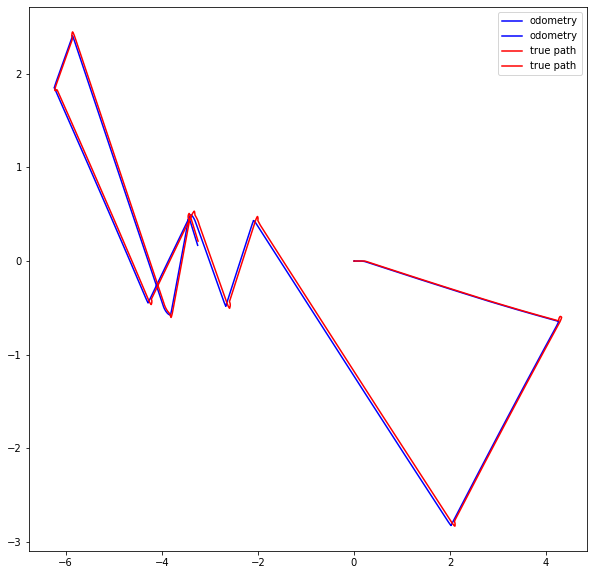

In [17]:
mr.kinematicModel.plot_paths()

The grid map is  340 x 240 .


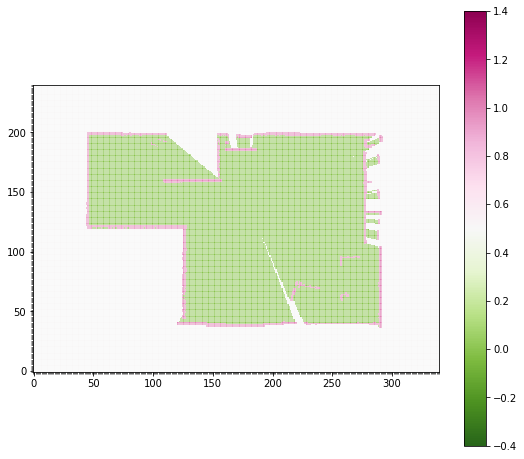

In [18]:
mr.point_cloud.compute_grid_ocupation()
mr.point_cloud.plot_grid_ocupation()

In [ ]:
mr.point_cloud.update_grid_map_pos_points()
mr.point_cloud.plot_grid_map_pos_points()

In [ ]:
#Tem um bug nesse plot que nao mostra a figura toda
#quando a simulação é re-iniciada várias vezes
# mr.point_cloud.plot_countour()

In [ ]:
# planning_animation(room_countour[0], room_countour[1], 0.46)

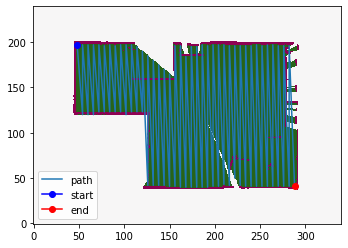

In [21]:
reso = 0.46
# room_countour = mr.point_cloud.get_room_countour()
# px, py = planning(room_countour[0], room_countour[1], reso)
mr.do_planning()
#planning_animation(room_countour[0], room_countour[1], reso)

In [ ]:
plan_plot = Planning()
x, y = plan_plot.get_path(mr.point_cloud.pmap)
np.array([ mr.point_cloud.get_pos_from_idx(x[i], y[i]) for i in range(len(x))]).T

In [ ]:
mr.plot_planning()

In [ ]:
mr.start(2000)

Avoid Obstacle. Position:  [0.5911673903465271, 2.5376477241516113] to [0, 0]41942596414Next Planned step  0 / 80 -6.6 2.85
Avoid Obstacle. Position:  [0.5786493420600891, 2.3848178386688232] to [-6.6, 2.85]922223Next Planned step  1 / 80 -6.3 -1.0
Avoid Obstacle. Position:  [4.457395553588867, 2.544890880584717] to [-6.3, -1.0]]88461696Next Planned step  2 / 80 -6.3 2.85
Avoid Obstacle. Position:  [0.5081035494804382, 2.2336740493774414] to [-6.3, 2.85].85]Next Planned step  3 / 80 -6.0 -1.0
Avoid Obstacle. Position:  [0.5080982446670532, 2.2336621284484863] to [-6.0, -1.0]Next Planned step  4 / 80 -6.0 2.85
Avoid Obstacle. Position:  [0.5080982446670532, 2.233656883239746] to [-6.0, 2.85]]Next Planned step  5 / 80 -5.7 -1.0
Avoid Obstacle. Position:  [-0.9411738514900208, 1.37709641456604] to [-5.7, -1.0]0]Next Planned step  6 / 80 -5.7 2.85
Avoid Obstacle. Position:  [-0.8395266532897949, 1.9952170848846436] to [-5.7, 2.85] 2.85]Next Planned step  7 / 80 -5.4 -0.85
Avoid Obstacle. P

Start _GotoGoal Subsumption Behavior_ without set a destination point. Thus robot goes to Global origin (0,0). For set a point, write __mr.setGoal(x,y)__ bellow before start function.

## Conclusion: ##

__Video URL:__ http://youtube.com